In [ ]:
!wget "https://raw.githubusercontent.com/mne-tools/mne-python/master/requirements.txt"
!pip install -r "/content/requirements.txt"
!pip install -U mne
!pip install tensorflow==2.0.0

--2020-03-18 01:25:39--  https://raw.githubusercontent.com/mne-tools/mne-python/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     482  --.-KB/s    in 0s      

2020-03-18 01:25:40 (39.0 MB/s) - ‘requirements.txt’ saved [482/482]

     / 450kB 85.6MB/s
     \ 3.5MB 103.0MB/s
     |████████████████████████████████| 63.5MB 56kB/s 
     |████████████████████████████████| 256kB 43.8MB/s 
     |████████████████████████████████| 727kB 45.0MB/s 
     |████████████████████████████████| 8.1MB 17.9MB/s 
     |████████████████████████████████| 7.0MB 36.1MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 2.5

In [ ]:
%matplotlib inline
import mne
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import csv
import sys
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# paths to dataset
cont_data = scipy.io.loadmat('/content/drive/Shared drives/eeg_data/Contaminated_Data.mat')
clean = scipy.io.loadmat('/content/drive/Shared drives/eeg_data/Pure_Data.mat')
veog_data = scipy.io.loadmat('/content/drive/Shared drives/eeg_data/VEOG.mat')
heog_data = scipy.io.loadmat('/content/drive/Shared drives/eeg_data/HEOG.mat')

Creating RawArray with float64 data, n_channels=19, n_times=5601
    Range : 0 ... 5600 =      0.000 ...    28.000 secs
Ready.


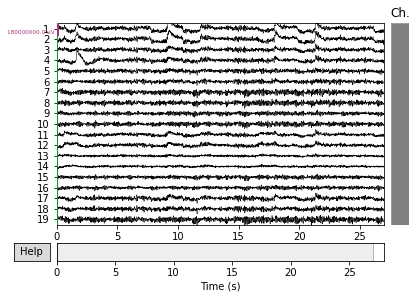

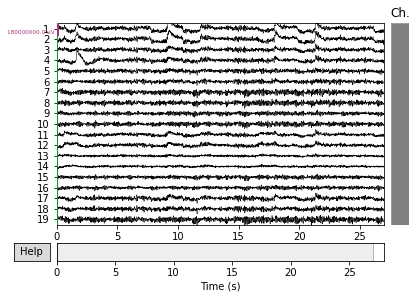

In [ ]:
# let's see an example of one of the simulations
ch_names = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"]
info = mne.create_info(ch_names=ch_names, sfreq=200, ch_types="eeg")
sim1_con = cont_data["sim1_con"]
raw = mne.io.RawArray(sim1_con, info)
raw.plot(duration=27, scalings=90)

Creating RawArray with float64 data, n_channels=4, n_times=600
    Range : 0 ... 599 =      0.000 ...     2.995 secs
Ready.


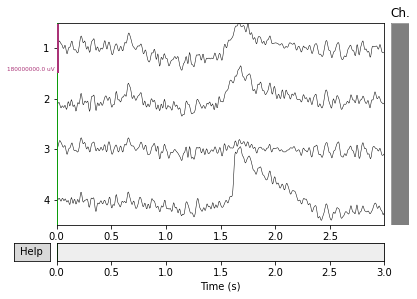

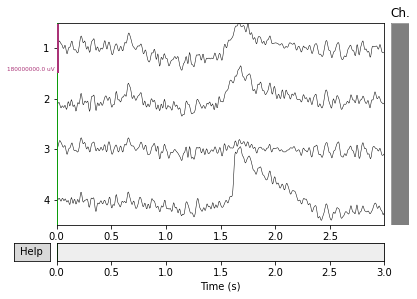

In [ ]:
# one simulation contains a lot of information
# let's take a closer look at one of the artifacts. Reduce the number of channels to 1-4 and seconds to 0-5.
# we can see the waves in channels 1,2, and 4 act abnormally between seconds 1-3
ch_names = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"]
info = mne.create_info(ch_names=ch_names[0:4], sfreq=200, ch_types="eeg")
sim1_con_5secs = sim1_con[0:4,0:3*200]
raw = mne.io.RawArray(sim1_con_5secs, info)
raw.plot(duration=27, scalings=90)

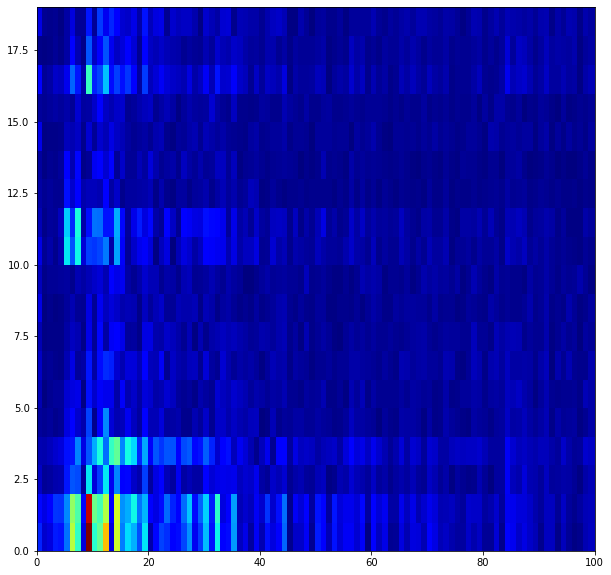

In [ ]:
# Let's apply fft to sim1... answer why

x = tf.convert_to_tensor(
    sim1_con,
    dtype=tf.float32
)

xt = tf.signal.rfft(
    x, #the data
    fft_length= [200*28], #the fft window~we want it to be sampling_rate * number of seconds
    name=None
)

xt =  2.0/(200)*tf.abs(xt[:,0:200])  

xn = np.array(xt)
xn = xn[:,0:100]

xn_max = xn.max()
xn_min = xn.min()

plt.figure(figsize = (10,10))
plt.pcolormesh(xn,vmax = xn_max, vmin= xn_min, cmap='jet')
plt.show()

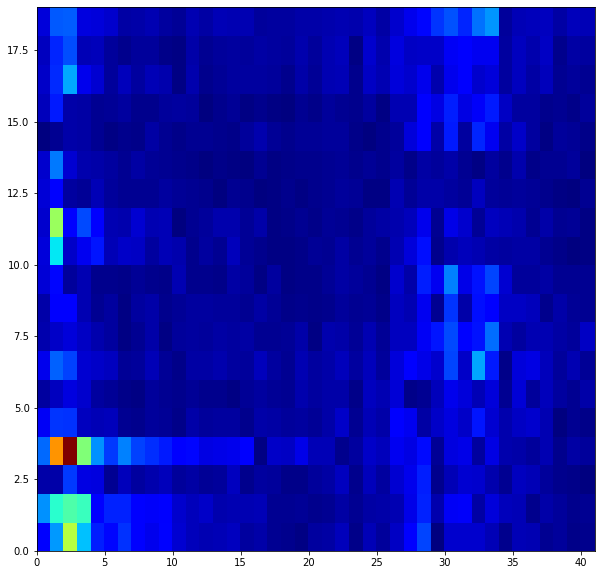

In [ ]:
# most of the activity occurs in the hertz range 0-40.
#   

x = tf.convert_to_tensor(
    sim1_con[:,0:200*3],
    dtype=tf.float32
)

xt = tf.signal.rfft(
    x, #the data
    fft_length= [200*3], #the fft window~we want it to be sampling_rate * number of seconds
    name=None
)

xt =  2.0/(200)*tf.abs(xt[:,0:200])  

xn = np.array(xt)
# crop hertz range
xn = xn[:,0:41]

xn_max = xn.max()
xn_min = xn.min()

plt.figure(figsize = (10,10))
plt.pcolormesh(xn,vmax = xn_max, vmin= xn_min, cmap='jet')
plt.show()

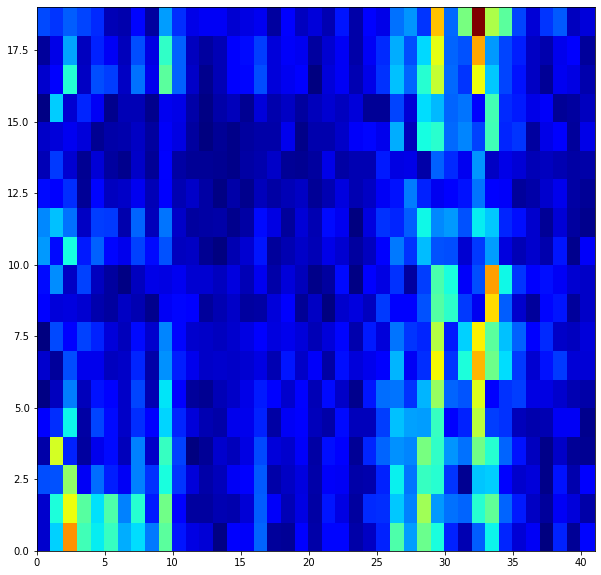

In [ ]:
# Let's compare it to seconds 5-8 seconds, where there is no artifact

x = tf.convert_to_tensor(
    sim1_con[:,200*5:200*8],
    dtype=tf.float32
)

xt = tf.signal.rfft(
    x, #the data
    fft_length= [200*3], #the fft window~we want it to be sampling_rate * number of seconds
    name=None
)

xt =  2.0/(200)*tf.abs(xt[:,0:200])  

xn = np.array(xt)
xn = xn[:,0:41]

xn_max = xn.max()
xn_min = xn.min()

plt.figure(figsize = (10,10))
plt.pcolormesh(xn,vmax = xn_max, vmin= xn_min, cmap='jet')
plt.show()

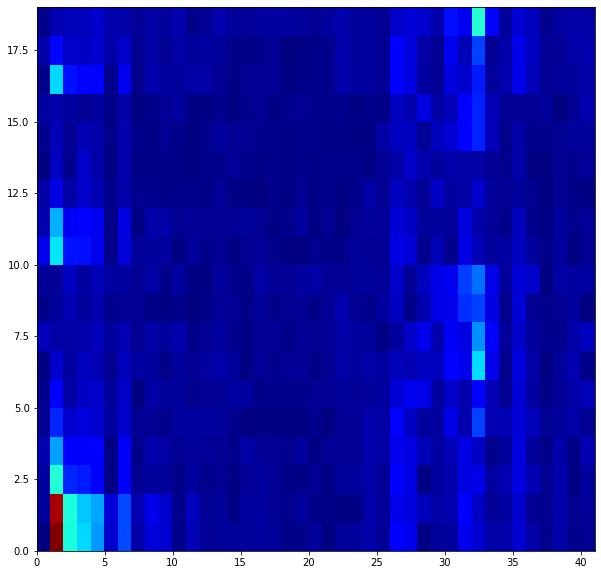

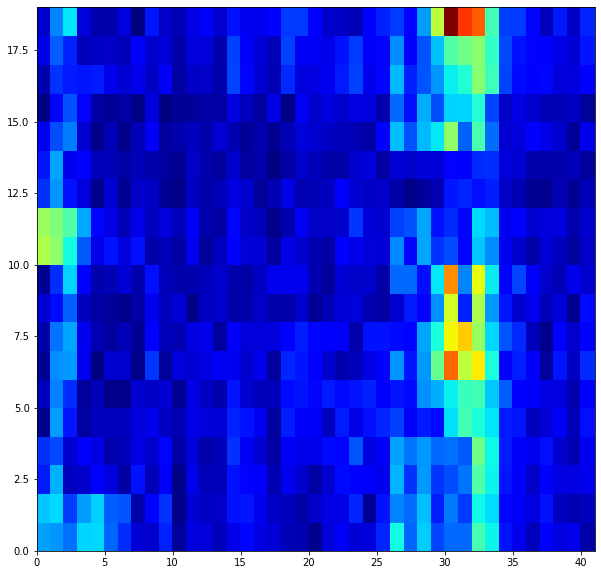

In [ ]:
# from seconds 0-3 where there is an artifact, there doesn't seem to be as high mV values as
# from seconds 5-8 where there isnt an artifact at the frequency 25-35
# let's plot another example of an interval with an artifact and an interval without an artifact.

# with artifact 8-11 seconds

x = tf.convert_to_tensor(
    sim1_con[:,200*8:200*11],
    dtype=tf.float32
)

xt = tf.signal.rfft(
    x, #the data
    fft_length= [200*3], #the fft window~we want it to be sampling_rate * number of seconds
    name=None
)

xt =  2.0/(200)*tf.abs(xt[:,0:200])  

xn = np.array(xt)
xn = xn[:,0:41]

xn_max = xn.max()
xn_min = xn.min()

plt.figure(figsize = (10,10))
plt.pcolormesh(xn,vmax = xn_max, vmin= xn_min, cmap='jet')
plt.show()



# without artifact, 14-17 seconds

x = tf.convert_to_tensor(
    sim1_con[:,200*14:200*17],
    dtype=tf.float32
)

xt = tf.signal.rfft(
    x, #the data
    fft_length= [200*3], #the fft window~we want it to be sampling_rate * number of seconds
    name=None
)

xt =  2.0/(200)*tf.abs(xt[:,0:200])  

xn = np.array(xt)
xn = xn[:,0:41]

xn_max = xn.max()
xn_min = xn.min()

plt.figure(figsize = (10,10))
plt.pcolormesh(xn,vmax = xn_max, vmin= xn_min, cmap='jet')
plt.show()

#print(len(xn.flatten()))

In [ ]:
# Great! The data post-fft exhibits a different pattern when containing an artifact and when not.
# Thus, we can feed this data post fft into our model.
# Let's create our preprocessed data

# there are 54 simulations, each with 27 seconds of data. 
# Thus, we will have 54 x 27 /3 = 486 different segments of data
# The length of a flattened segment is 779
# The shape of our data will be 486 x 779
data = np.empty(shape=(486,779), dtype=float, order='C')
counter = 0

for i in range(1,55):
  sim = cont_data["sim" + str(i) + "_con"]
  # 28 seconds
  for j in range(0,26,3):
    x = tf.convert_to_tensor(
        # 3 second interval
        sim[:,200*j:200*j+3],
        dtype=tf.float32
    )

    xt = tf.signal.rfft(
        x, #the data
        fft_length= [200*3], #the fft window~we want it to be sampling_rate * number of seconds
        name=None
    )

    xt =  2.0/(200)*tf.abs(xt[:,0:200])  

    xn = np.array(xt)
    xn = xn[:,0:41]
    # 2d -> 1d
    xn = xn.flatten()

    data[counter] = xn
    
    #print("sim"+str(i)+": ["+ str(j) + ":" + str(j + 3) + "] Counter is " + str(counter))#, debug
    counter = counter + 1

#print(data)

Creating RawArray with float64 data, n_channels=4, n_times=6001
    Range : 0 ... 6000 =      0.000 ...    30.000 secs
Ready.


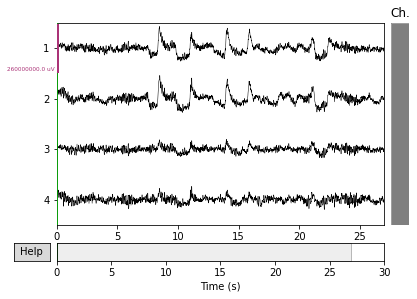

Creating RawArray with float64 data, n_channels=4, n_times=600
    Range : 0 ... 599 =      0.000 ...     2.995 secs
Ready.


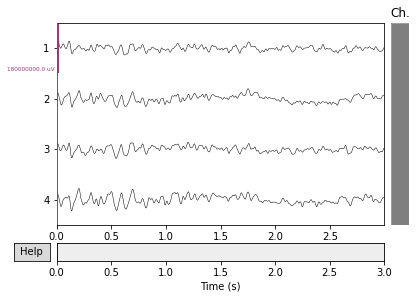

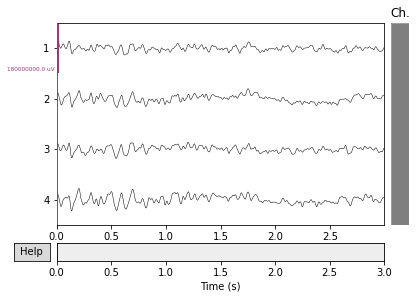

In [ ]:
# Create our labels. We are manually doing this...
# Use this to help identify artifacts

i = 19        #file
a = 24        # start
b = a+3       # end
sim = cont_data["sim"+str(i)+"_con"]

ch_names = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"]
info = mne.create_info(ch_names=ch_names[0:4], sfreq=200, ch_types="eeg")
raw = mne.io.RawArray(sim[0:4], info)
raw.plot(duration=27, scalings=130)


#window = lambda x:  np.concatenate((x[0:4,a*200:b*200],x[10:12,a*200:b*200]),axis=0)
window = lambda x:  x[0:4,a*200:b*200]
ch_names = ["1","2","3","4"]
info = mne.create_info(ch_names=ch_names, sfreq=200, ch_types="eeg")
raw = mne.io.RawArray(window(sim), info)
raw.plot(duration=27, scalings=90)

In [ ]:
# labels, labeled manually
s1 = [1,0,0,1,0,0,1,1,1]
s2 = [1,0,0,0,0,1,1,1,0]
s3 = [0,1,0,1,1,1,0,1,1]
s4 = [0,1,0,1,1,1,1,0,0]
s5 = [0,1,1,0,0,0,0,1,1]
s6 = [1,1,0,1,1,1,0,1,1]
s7 = [0,0,1,0,1,0,1,0,1]
s8 = [0,1,1,1,1,1,1,0,1]
s9 = [0,0,1,0,1,1,0,1,1]
s10 = [1,1,0,1,1,0,0,1,0]
s11 = [1,1,1,0,1,1,1,0,1]
s12 = [1,1,0,0,0,1,1,0,1]
s13 = [1,0,0,0,1,0,1,0,1]
s14 = [1,1,0,1,0,0,1,1,1]
s15 = [0,1,1,1,1,0,1,1,1]
s16 = [1,0,1,1,1,1,0,1,1]
s17 = [1,1,0,1,1,1,1,0,1]
s18 = [0,0,1,1,1,1,1,1,0]
s19 = [0,0,1,1,1,1,0,1,0]
s20 = [1,1,0,0,1,1,1,1,1]
s21 = [1,1,1,0,1,1,0,1,1]
s22 = [1,1,1,1,1,0,1,1,0]
s23 = [1,0,0,0,0,1,0,0,0]
s24 = [0,0,0,1,0,0,1,0,1]
s25 = [1,1,1,1,0,1,1,1,1]
s26 = [1,1,1,0,1,0,1,1,1]
s27 = [1,0,1,0,0,1,1,1,0]
s28 = [1,0,1,0,0,1,0,0,1]
s29 = [1,0,0,1,1,1,1,1,1]
s30 = [1,1,1,1,1,1,0,1,1]
s31 = [1,1,1,1,1,0,0,1,0]
s32 = [0,0,0,1,1,1,1,0,1]
s33 = [1,1,0,1,0,0,0,0,1]
s34 = [1,1,1,1,1,0,0,1,0]
s35 = [0,1,0,1,1,1,1,1,0]
s36 = [1,0,1,0,0,0,0,0,1]
s36 = [1, 0, 1, 0, 0, 0, 0, 0, 0]
s37 = [1, 1, 1, 1, 1, 1, 1, 0, 0]
s38 = [1, 1, 1, 0, 0 ,1, 1, 1, 1]
s39 = [1, 1, 1, 1, 1, 1, 1, 1, 1]
s40 = [1, 1, 0, 1, 1, 1, 1, 0, 1]
s41 = [1, 1, 1, 0, 1, 0, 1, 0, 1]
s42 = [1, 0, 1, 0, 0, 1, 1, 1, 0]
s43 = [0, 0, 1, 1, 0, 1, 0, 0, 1]
s44 = [1, 1, 0, 1, 1, 0, 1, 1, 0]
s45 = [1, 0, 1, 0, 1, 0, 0, 1, 1]
s46 = [1 ,1, 1, 1, 1, 0, 1, 1, 0]
s47 = [1, 0, 1, 1, 1, 1, 1, 1, 1]
s48 = [0, 1, 1, 1, 1, 0, 1, 1, 0]
s49 = [1, 1, 0, 0, 0, 0, 1, 1, 1]
s50 = [1, 0, 1, 1, 1, 1, 0, 1, 0]
s51 = [1, 1, 1, 1, 0, 1, 1, 1, 0]
s52 = [1, 1, 1, 1, 0, 1, 1, 0, 0]
s53 = [1, 0, 0, 0, 1, 1, 1, 1 ,0]
s54 = [1, 1, 0, 1, 1, 1, 0, 0 ,1]

labels = s1+s2+s3+s4+s5+s6+s7+s8+s9+s10+s11+s12+s13+s14+s15+s16+s17+s18+s19+s20+s21+s22+s23+s24+s25+s26+s27+s28+s29+s30+s31+s32+s33+s34+s35+s36+s37+s38+s39+s40+s41+s42+s43+s44+s45+s46+s47+s48+s49+s50+s51+s52+s53+s54
labels = np.asarray(labels)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 2 hidden layers, overfit
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, activation='relu'))
model.add(layers.Dense(400, activation='relu'))
model.add(layers.Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=20, epochs=300, validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

In [ ]:
# 2 hidden layers, apply dropout, still overfit 
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, activation='relu'))
model.add(Dropout(.2))
model.add(layers.Dense(400, activation='relu'))
model.add(Dropout(.2))
model.add(layers.Dense(150, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=32, epochs=300, validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

In [ ]:
# 2 hidden layers, apply regularization, still overfit
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dense(400, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dense(150, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=32, epochs=300, validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

In [ ]:
# 3 hidden layers, far too overfit
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=32, epochs=300, validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

In [ ]:
# 2 hidden layers, apply dropout and regularization, still overfit 
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(.2))
model.add(layers.Dense(400, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(.2))
model.add(layers.Dense(150, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=32, epochs=400 , validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

In [ ]:
# 1 hidden layer, still overfit
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=32, epochs=300, validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

In [ ]:
# 3 hidden layers, far too overfit
model = tf.keras.Sequential()
# Adds a densely-connected layer with 779 units to the model:
model.add(layers.Dense(779, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit(x=data, y=labels, batch_size=20, epochs=300, validation_split=0.2)

#Evaluate the model's performance
train_loss, train_acc = model.evaluate(data[0:388], labels[0:388])
test_data = data[388:]
test_labels = labels[388:]

# train_loss, train_acc = model.evaluate(data, labels)
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('Training set accuracy:', train_acc)
#print('Training set loss:', train_loss)
print('Test set accuracy:', test_acc)
#print('Test set Loss:', train_loss)

Train on 388 samples, validate on 98 samples
Epoch 1/300
388/388 [==============================] - 1s 2ms/sample - loss: 0.6528 - acc: 0.6340 - val_loss: 0.6136 - val_acc: 0.6735
Epoch 2/300
388/388 [==============================] - 0s 473us/sample - loss: 0.6378 - acc: 0.6340 - val_loss: 0.6124 - val_acc: 0.6735
Epoch 3/300
388/388 [==============================] - 0s 481us/sample - loss: 0.6322 - acc: 0.6340 - val_loss: 0.6102 - val_acc: 0.6735
Epoch 4/300
388/388 [==============================] - 0s 485us/sample - loss: 0.6304 - acc: 0.6340 - val_loss: 0.6049 - val_acc: 0.6735
Epoch 5/300
388/388 [==============================] - 0s 492us/sample - loss: 0.6239 - acc: 0.6340 - val_loss: 0.6021 - val_acc: 0.6735
Epoch 6/300
388/388 [==============================] - 0s 480us/sample - loss: 0.6210 - acc: 0.6340 - val_loss: 0.6011 - val_acc: 0.6735
Epoch 7/300
388/388 [==============================] - 0s 476us/sample - loss: 0.6183 - acc: 0.6340 - val_loss: 0.6119 - val_acc: 0.673

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  607620    
_________________________________________________________________
dense_1 (Dense)              multiple                  390000    
_________________________________________________________________
dense_2 (Dense)              multiple                  50100     
_________________________________________________________________
dense_3 (Dense)              multiple                  35350     
_________________________________________________________________
dense_4 (Dense)              multiple                  351       
Total params: 1,083,421
Trainable params: 1,083,421
Non-trainable params: 0
_________________________________________________________________


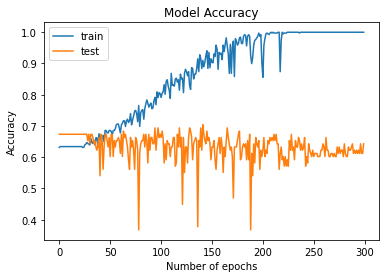

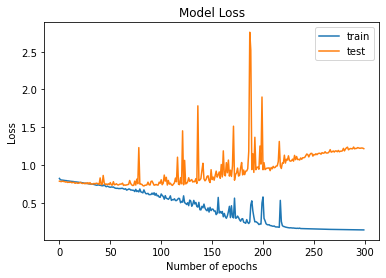

In [ ]:
### YOUR CODE HERE ###
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()